<h1><b>Stock Price Prediction</b></h1>

<h6><b>Name: Chitra Raghavendrarao Krishnarao</b></h6>
<h6><b>Andrew ID: crkrishn</b></h6>

---


<h3><b>Libraries</b></h3>



In [1]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
import math

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


<h3><b>Methods and Classes</b></h3>





We define certain essential classes and methods for constructing, training, testing and evaluating the machine learning model

In [2]:
#method to retrieve the stock date for the given start and end dates using yahoofinance
def retrieve_stock_data(start_date, end_date):

  #set ticker symbol
  ticker = 'GME'

  #convert dates to appropriate format
  start_date = datetime.datetime(*start_date)
  end_date = datetime.datetime(*end_date)

  #get data
  gme_data = yf.Ticker(ticker)

  #get data for required time period
  gme_history = gme_data.history(start=start_date, end=end_date)

  #convert the retrieved data to a pandas DataFrame
  gme_df = pd.DataFrame(gme_history)

  return gme_df


In [3]:
#method to visualize existing stock trend
def disp_stock_trend(gme_df):
  #reset the index to convert the datetime index to a column
  gme_df.reset_index(inplace=True)

  #rename the index column to "Date"
  gme_df.rename(columns={'index': 'Date'}, inplace=True)

  #plot stock market trend

  #ensure the 'Date' column is in datetime format for proper plotting
  gme_df['Date'] = pd.to_datetime(gme_df['Date'])

  # Setting the plot size for better readability
  plt.figure(figsize=(14, 7))

  # Plotting the actual closing prices in the training period
  plt.plot(gme_df['Date'], gme_df['Close'], label='Close', color='blue', marker='o')

  # Adding title and labels with font size adjustments
  plt.title('Closing Prices for GME', fontsize=16)
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Closing Price', fontsize=14)

  # Rotating date labels for better visibility
  plt.xticks(rotation=45)

  # Adding a legend to distinguish the actual values
  plt.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()

In [4]:
#pre-process dataframe for training; create sequences from t-1 to t-k days such that the closing price on the tth day has to be predicted (y value)
def form_sequences(df, k):
    df = dc(df)
    df.set_index('Date', inplace=True)

    for i in range(1, k+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    #since it's currently from t-1 to t-k, change column ordering to make it from t-k to t-1
    columns = df.columns.tolist()  # Get the list of column names
    new_columns = columns[:1] + columns[1:][::-1]  # Retain the first column and reverse the remaining columns
    df = df[new_columns]  # Reassign the DataFrame with the new column ordering

    return df

In [5]:
#perform min-max scaling such that the data lies between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

#method to perform pre-processing on data and separate features and labels
def perform_pre_processing(processed_stock_df):
  #convert to numpy
  stock_df_np = processed_stock_df.to_numpy()

  stock_df_np_transformed = scaler.fit_transform(stock_df_np)
  stock_df_np_transformed[:5]

  #store features in X and labels in y
  X = stock_df_np_transformed[:,1:]
  y = stock_df_np_transformed[:,0]

  return (X,y)

In [6]:
#split the dataset into train and test sets; perform additional essential pre-processing for Pytorch
def split_train_test(X,y,partition_index,seq_size):
  #split datasets based on above index obtained
  X_train = X[:partition_index]
  X_test = X[partition_index:]

  y_train = y[:partition_index]
  y_test = y[partition_index:]

  print("X before reshaping:",X_train.shape)

  #reshape model to fulfil pytorch requirements of an additional dimension towards the end
  X_train = X_train.reshape((-1,seq_size,1))
  y_train = y_train.reshape((-1,1))

  X_test = X_test.reshape((-1,seq_size,1))
  y_test = y_test.reshape((-1,1))

  print("X after reshaping:",X_train.shape)

  #wrap them in tensors and return the test and train sets
  X_train = torch.tensor(X_train).float()
  X_test = torch.tensor(X_test).float()
  y_train = torch.tensor(y_train).float()
  y_test = torch.tensor(y_test).float()

  print("X after wrapping in tensor:",X_train.shape)

  return (X_train, y_train, X_test, y_test)

In [7]:
#make datasets using the tensors

class StockPredictionDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    return self.X[i], self.y[i]

In [8]:
class LSTM(nn.Module):
  #parameterized constructor
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size,1)

  #initialize batch_size and gates
  def forward(self,x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x,(h0,c0))
    out = self.fc(out[:,-1,:])
    return out

In [9]:
def train_epoch(epoch, loss_function, optimizer,train_loader,batch_size,model,train_loss):
  model.train(True)
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_loss_across_batches = running_loss/len(train_loader)

  train_loss.append(avg_loss_across_batches)

In [10]:
def test_epoch(loss_function,test_loader,model, test_loss):
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss/len(test_loader)

  test_loss.append(avg_loss_across_batches)

In [11]:
#method to perform training + testing
def train_test_model(learning_rate, num_epochs,train_loader,test_loader,batch_size,model) :
  learning_rate = learning_rate
  num_epochs = num_epochs
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss=[]
  test_loss=[]

  performance=[]

  for epoch in range(num_epochs):
    train_epoch(epoch=epoch, loss_function=loss_function, optimizer=optimizer,train_loader=train_loader,batch_size=batch_size,model=model,train_loss=train_loss)
    test_epoch(loss_function=loss_function,test_loader=test_loader,model=model,test_loss=test_loss)
    performance.append([epoch+1,train_loss[epoch],test_loss[epoch]])


  return performance

In [12]:
from operator import index
#method to visualize actual versus predicted values and assess performance of the model
def visualize_actual_predicted(X, y,seq_size,model,title='',test_mode=False, ax=None):
  with torch.no_grad():
    pred = model(X.to(device)).to('cpu').numpy()

  #parition indices and choose dates based on whether the mode is training or testing
  if test_mode is True:
    dates = dates_df.iloc[partition_index:]
  else:
    dates = dates_df.iloc[:partition_index]

  #decrease the dimensions from 9 to 7 if it includes sentiment data; since the original dataset had only 7 features during min-max scaling, the same dimensions
  #have to be maintained while reverting that to obtain original stock price values
  if sentiment_exec :
    X = X[:, :7, :]

  #descale data
  train_predictions = pred.flatten()
  dummies = np.zeros((X.shape[0], seq_size+1))
  dummies[:,0] = train_predictions
  dummies = scaler.inverse_transform(dummies)

  train_predictions = dc(dummies[:,0])

  dummies = dummies = np.zeros((X.shape[0], seq_size+1))
  dummies[:,0] = y.flatten()
  dummies = scaler.inverse_transform(dummies)

  y_values = dc(dummies[:,0])

  pred = train_predictions
  y = y_values

  print("y range: ",np.min(y),np.max(y))

  if ax is None:
    plt.figure()
    ax = plt.gca()
  ax.plot( dates['Date'],y, label = 'Actual Closing Price')
  ax.plot(dates['Date'],pred, label = 'Predicted Closing Price')
  ax.set_xlabel('Date')
  ax.set_title(title)
  ax.tick_params(axis='x', rotation=45)
  ax.set_ylabel('Closing Price')
  ax.legend()

  #calculate MSE, RMSE and MAE
  mse = mean_squared_error(y, pred)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(y, pred)
  print("\n\nMean Squared Error (MSE):", mse)
  print("Root Mean Squared Error (RMSE):", rmse)
  print("Mean Absolute Error (MAE):", mae)


In [13]:
#method to visualize sentiment data and loss function data
def visualize_data(x_values, y1_values, y2_values,x_label,y_label,y1_label,y2_label,y1_color,y2_color,title='', ax=None):

  if ax is None:
    plt.figure
    ax = plt.gca()

  ax.plot( x_values,y1_values, label = y1_label, color = y1_color)
  ax.plot( x_values,y2_values, label = y2_label, color = y2_color)
  ax.set_xlabel(x_label)
  ax.set_title(title)
  ax.tick_params(axis='x', rotation=45)
  ax.set_ylabel(y_label)
  ax.legend()

In [14]:
#method to visualize prediction and sentiment data
def visualize_sentiment_pred_data(pred_x_values, pred_y_values, pred_label, sentiment_x_values, sentiment_y_pos_values, sentiment_y_neg_values,sentiment_label,seq_size,model,pred_bool_val=False):

  #create a figure and two subplots
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  #plot the first graph on the left subplot
  visualize_actual_predicted(X=pred_x_values, y=pred_y_values, seq_size=seq_size,title=pred_label,model=model,test_mode=pred_bool_val,ax=axs[0])

  #plot the second graph on the right subplot
  visualize_data(x_values=sentiment_x_values, y1_values=sentiment_y_pos_values, y2_values=sentiment_y_neg_values, x_label='Date',y_label='Sentiment Score',y1_label='Positive',y2_label='Negative',y1_color='green',y2_color='red',title = sentiment_label,ax=axs[1])

  #adjust layout to prevent overlap
  plt.tight_layout()

  #show the plots
  plt.show()

Link to reddit sentiment data - https://dataverse.harvard.edu/file.xhtml?fileId=6370001&version=3.0

<h3><b>I. Stock Price Prediction Using Historic Stock Data</b></h3>

<h4><b>1. Retrieve Historic Stock Data from Jan 2021-Sept 2021</b></h4>

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
#variable is set to True while combining the historic dataset with the sentiment analysis dataset
sentiment_exec = False

In [17]:
'''
Set the start date to Jan 1, 2021 the end date to Sept 1, 2021, and fetch stock data for that time-frame
'''
start_date = (2021,1,1)
end_date = (2021,9,1)
temp_df = retrieve_stock_data(start_date, end_date)

temp_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04 00:00:00-05:00,4.7500,4.7750,4.2875,4.3125,40090000,0.0,0.0
2021-01-05 00:00:00-05:00,4.3375,4.5200,4.3075,4.3425,19846000,0.0,0.0
2021-01-06 00:00:00-05:00,4.3350,4.7450,4.3325,4.5900,24224800,0.0,0.0
2021-01-07 00:00:00-05:00,4.6175,4.8625,4.5050,4.5200,24517200,0.0,0.0
2021-01-08 00:00:00-05:00,4.5450,4.5750,4.2700,4.4225,25928000,0.0,0.0


In [18]:
gme_df = temp_df
gme_df.shape

(167, 7)

In [19]:
gme_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-08-25 00:00:00-04:00,51.662498,56.750000,48.250000,49.912498,51444400,0.0,0.0
2021-08-26 00:00:00-04:00,50.169998,54.250000,49.750000,51.305000,24954400,0.0,0.0
2021-08-27 00:00:00-04:00,51.924999,53.250000,50.005001,51.237499,12923200,0.0,0.0
2021-08-30 00:00:00-04:00,51.250000,54.547501,50.755001,52.299999,13238400,0.0,0.0
2021-08-31 00:00:00-04:00,53.174999,55.575001,52.865002,54.560001,14298800,0.0,0.0


In [20]:
gme_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,167.000000,167.000000,167.000000,167.000000,1.670000e+02,167.0,167.0
mean,40.840539,44.088832,37.640060,40.453248,8.142713e+07,0.0,0.0
std,17.531919,19.301404,15.769420,16.902798,1.336162e+08,0.0,0.0
min,4.335000,4.520000,4.270000,4.312500,3.781600e+06,0.0,0.0
25%,36.158751,39.423750,32.437500,36.001249,1.425960e+07,0.0,0.0
50%,42.537498,44.744999,40.305000,42.259998,3.026080e+07,0.0,0.0
75%,51.225000,54.228750,47.552500,50.572500,8.119180e+07,0.0,0.0
max,94.927498,120.750000,72.877502,86.877502,7.886316e+08,0.0,0.0


In [21]:
gme_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

<h4><b>2.GME Stock Data Trends</b></h4>

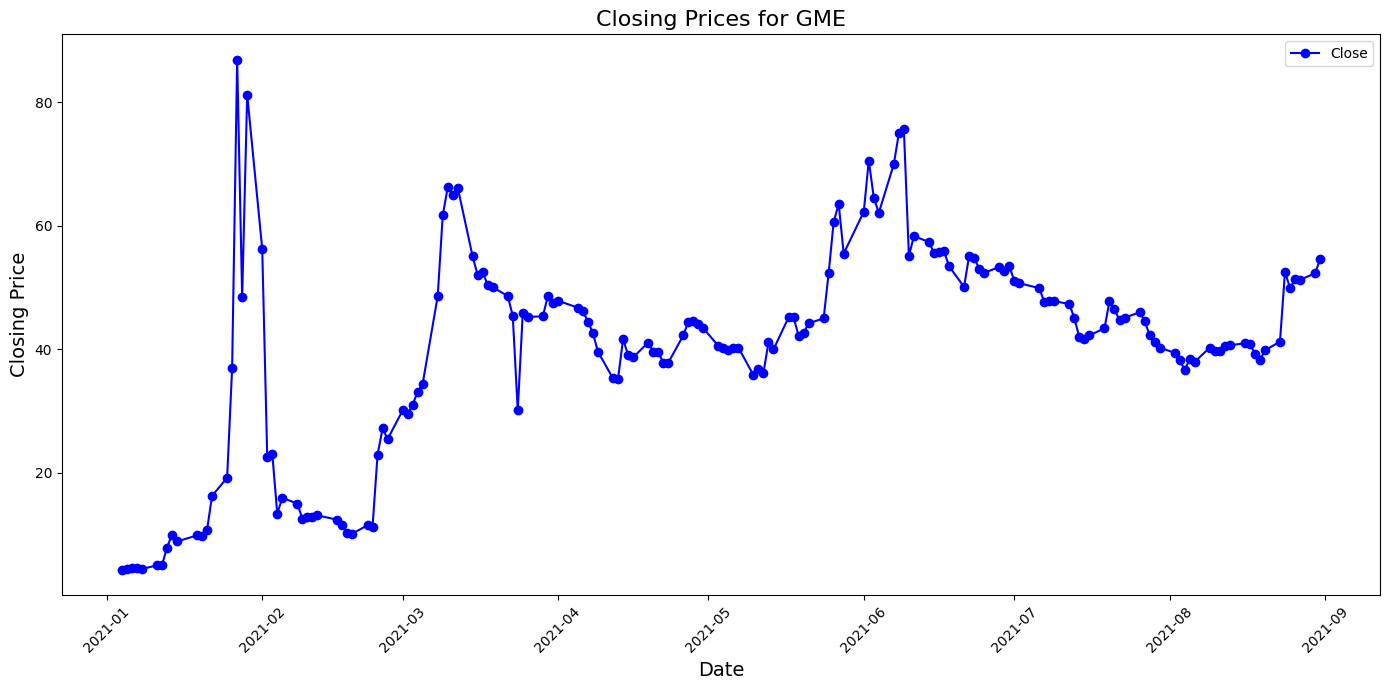

In [22]:
#visualize stock prices for the entire time-frame
disp_stock_trend(gme_df)

In [23]:
gme_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          167 non-null    datetime64[ns, America/New_York]
 1   Open          167 non-null    float64                         
 2   High          167 non-null    float64                         
 3   Low           167 non-null    float64                         
 4   Close         167 non-null    float64                         
 5   Volume        167 non-null    int64                           
 6   Dividends     167 non-null    float64                         
 7   Stock Splits  167 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 10.6 KB


<h4><b>3.Data Pre-processing</b></h4>

<h5><b>3a.Sequence Formation</b></h5>

We store the data such that for day t, the record will store the stock prices of dats t-7 through t-1; the date coupled with the historic stock data become the features and the stock price for that day(t) becomes the label or output. In this step, we organize the data in this format.  

In [24]:
#set sequence size to 7 - since we'll be using 7 features; (t-7) to (t-1) days of historic data to predict the stock price on the tth day
sequence_size_stock = 7

#form sequences of (t-7) to (t-1) from the 8th record onwards
stock_df = gme_df[['Date', 'Close']].copy()
processed_stock_df = form_sequences(stock_df,sequence_size_stock)

processed_stock_df.head()

,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
Date,,,,,,,,
2021-01-13 00:00:00-05:00,7.8500,4.3125,4.3425,4.5900,4.5200,4.4225,4.9850,4.9875
2021-01-14 00:00:00-05:00,9.9775,4.3425,4.5900,4.5200,4.4225,4.9850,4.9875,7.8500
2021-01-15 00:00:00-05:00,8.8750,4.5900,4.5200,4.4225,4.9850,4.9875,7.8500,9.9775
2021-01-19 00:00:00-05:00,9.8400,4.5200,4.4225,4.9850,4.9875,7.8500,9.9775,8.8750
2021-01-20 00:00:00-05:00,9.7800,4.4225,4.9850,4.9875,7.8500,9.9775,8.8750,9.8400


In [25]:
#store the date values in a dataframe
dates_df = pd.DataFrame({'Date': processed_stock_df.index})
dates_df['Date'] = dates_df['Date'].dt.tz_localize(None)
dates_df.head()

,Date
0,2021-01-13
1,2021-01-14
2,2021-01-15
3,2021-01-19
4,2021-01-20


In [26]:
dates_df.tail()

,Date
155,2021-08-25
156,2021-08-26
157,2021-08-27
158,2021-08-30
159,2021-08-31


<h5><b>3b.Data Pre-Processing: Feature Scaling and Separate Features and Labels</b></h5>

We perform min-max scaling on the stock price such that the values lie between 0 and 1. Following this, we store the features and labels in separate numpy arrays.

In [27]:
#perform min-max scaling and store in numpy arrays
X_stock,y_stock = perform_pre_processing(processed_stock_df)
X_stock.shape, y_stock.shape

((160, 7), (160,))

<h4><b>4.Split Processed Stock Data into Train and Test Sets</b></h4>

In [28]:
#set index such that we use data from 01/01 to 05/31 for training and the remaining for testing
partition_index = dates_df[dates_df['Date'] > '2021-05-31'].index.min()

X_stock_train, y_stock_train, X_stock_test, y_stock_test = split_train_test(X_stock,y_stock,partition_index,sequence_size_stock)
X_stock_train.shape, y_stock_train.shape

X before reshaping: (95, 7)
X after reshaping: (95, 7, 1)
X after wrapping in tensor: torch.Size([95, 7, 1])


(torch.Size([95, 7, 1]), torch.Size([95, 1]))

In [29]:
#create train and test datasets
train_dataset_stock = StockPredictionDataset(X_stock_train, y_stock_train)
test_dataset_stock = StockPredictionDataset(X_stock_test, y_stock_test)

#wrap the datasets in data loaders for working with batches

batch_size_stock = 16

train_loader_stock = DataLoader(train_dataset_stock, batch_size=batch_size_stock, shuffle=True)
test_loader_stock = DataLoader(test_dataset_stock, batch_size=batch_size_stock, shuffle=False)

In [30]:
#validate batch size and dimensions
for _,batch in enumerate(train_loader_stock):
  x_batch,y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


<h4><b>5. Model Construction, Training, and Testing</b></h4>

In [31]:
#construct model
model_stock = LSTM(1,4,1)
model_stock.to(device)
model_stock

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [32]:
#perform training + testing
learning_rate_stock = 0.05
epochs_stock = 200

performance_stock = train_test_model(learning_rate=learning_rate_stock, num_epochs=epochs_stock, train_loader=train_loader_stock, test_loader=test_loader_stock,batch_size=batch_size_stock,model=model_stock)

performance_df_stock = pd.DataFrame(performance_stock, columns=['Epoch', 'Training Loss', 'Testing Loss'])


In [33]:
#view training and testing losses in tabular format
performance_df_stock_temp = performance_df_stock.style.hide(axis="index")
display(performance_df_stock_temp)

Epoch,Training Loss,Testing Loss
1,0.042812,0.010404
2,0.037443,0.031662
3,0.023155,0.005258
4,0.018923,0.015350
5,0.021742,0.004481
6,0.017469,0.009767
7,0.014495,0.003243
8,0.014518,0.003574
9,0.014117,0.004272
10,0.014326,0.003111


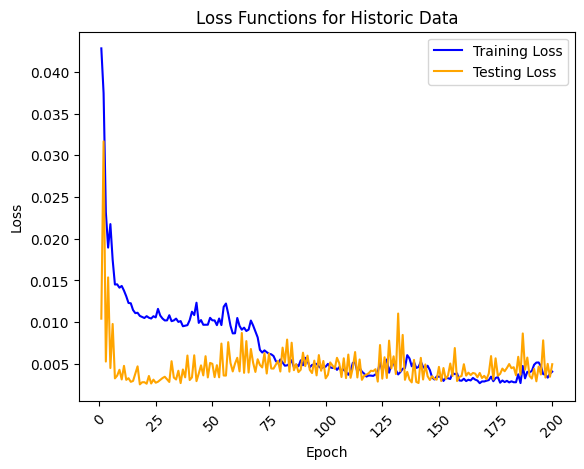

In [34]:
#plot loss functions
visualize_data(x_values=performance_df_stock['Epoch'],y1_values=performance_df_stock['Training Loss'], y2_values = performance_df_stock['Testing Loss'],x_label='Epoch',y_label='Loss',y1_label='Training Loss',
               y2_label='Testing Loss',y1_color='blue',y2_color='orange', title='Loss Functions for Historic Data')

<h4><b>6. Visualize Actual versus Predicted Stock Price Values</b></h4>

y range:  7.849999904632568 86.87750244140626


Mean Squared Error (MSE): 18.714693223687327
Root Mean Squared Error (RMSE): 4.326048222533739
Mean Absolute Error (MAE): 2.928601471159356


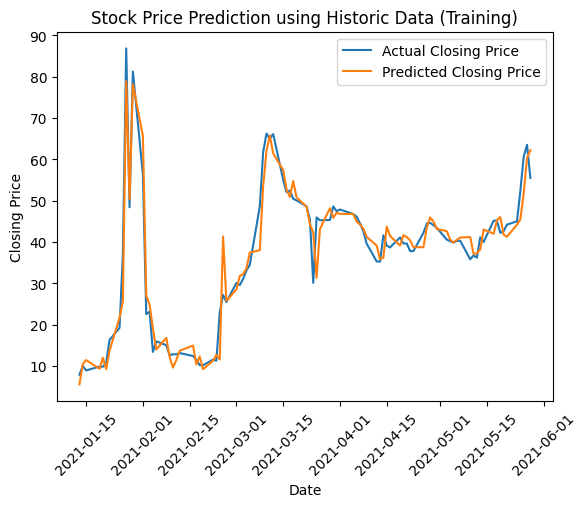

In [35]:
#visualize actual versus predicted prices for training model
visualize_actual_predicted(X=X_stock_train, y=y_stock_train, seq_size=sequence_size_stock, model = model_stock, title='Stock Price Prediction using Historic Data (Training)')

y range:  36.700001497168714 75.63999938118934


Mean Squared Error (MSE): 34.832718099687646
Root Mean Squared Error (RMSE): 5.901924948666125
Mean Absolute Error (MAE): 3.8550263040590815


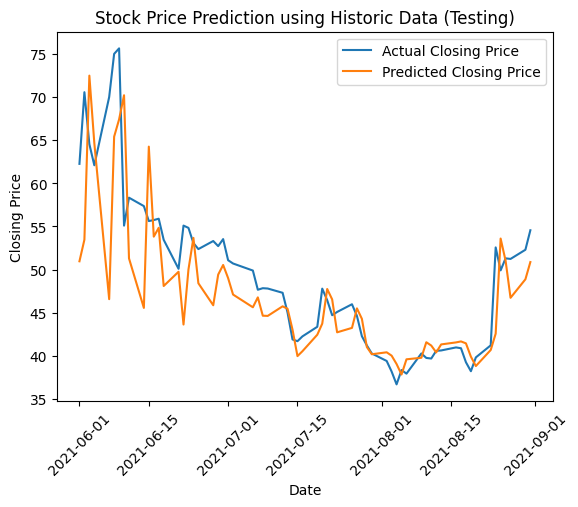

In [36]:
visualize_actual_predicted(X=X_stock_test, y=y_stock_test, seq_size=sequence_size_stock, model=model_stock, title='Stock Price Prediction using Historic Data (Testing)',test_mode=True)

<h3><b>II. Stock Price Prediction using Historic Data + Sentiment Analysis Data</b></h3>

<h4><b>1. Read Data from File</b></h4>

In [37]:
sentiment_data = ''
#extract sentiment data
sentiment_data = pd.read_csv('rGME_sentiment_reddit.csv')

<ipython-input-37-7e5c9a7f6e06>:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiment_data = pd.read_csv('rGME_sentiment_reddit.csv')


In [38]:
sentiment_data.shape

(1033236, 74)

In [39]:
sentiment_data.columns

Index(['Unnamed: 0', 'id', 'title', 'url', 'score', 'author', 'num_comments',
       'date', 'flair', 'compound', 'neg', 'neu', 'pos', 'spacy_title',
       'clean_text', 'char_count', 'word_count', 'word_count_cln',
       'stopword_count', 'pos_tags', 'dep_tags', '_NOUN', '_VERB', '_ADP',
       '_ADJ', '_DET', '_PROPN', '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV',
       '_PART', '_amod', '_ROOT', '_punct', '_advmod', '_auxpass',
       '_nsubjpass', '_ccomp', '_acomp', '_neg', '_nsubj', '_aux', '_agent',
       '_det', '_pobj', '_prep', '_csubj', '_nummod', '_attr', '_acl',
       '_relcl', '_dobj', '_pcomp', '_xcomp', '_cc', '_conj', '_mark', '_prt',
       '_compound', '_dep', '_advcl', '_parataxis', '_poss', '_intj', '_appos',
       '_npadvmod', '_predet', '_case', '_expl', '_oprd', '_dative', '_nmod'],
      dtype='object')

<h4><b>2. Perform Pre-Processing</b></h4>

<h5><b>2a. Retain only necessary columns</b></h5>

In [40]:
#retain only the date and sentiment scores for pos/neg columns
sentiment_data = sentiment_data[['date', 'pos', 'neg']]
sentiment_data.head()

,date,pos,neg
0,2021-01-04,0.811,0.000
1,2021-01-04,0.921,0.000
2,2021-01-05,0.256,0.000
3,2021-01-05,0.000,0.115
4,2021-01-06,0.000,0.000


In [41]:
sentiment_data.tail()

,date,pos,neg
1033231,2021-12-31,0.0,0.128
1033232,2021-12-31,0.0,0.783
1033233,2021-12-31,0.0,0.190
1033234,2021-12-31,0.0,0.000
1033235,2021-12-31,0.0,0.000


<h5><b>2b. Aggregate data for each day on the basis of the mean value for that day</b></h5>

In [42]:
#store only entry per date, average this out for the positive and negative sentiments
transformed_sentiment_data = sentiment_data.groupby('date').agg({'pos': 'mean', 'neg': 'mean'})

#reset index to make 'date' a regular column
transformed_sentiment_data.reset_index(inplace=True)

transformed_sentiment_data.head()

,date,pos,neg
0,2021-01-04,0.86600,0.0000
1,2021-01-05,0.12800,0.0575
2,2021-01-06,0.18850,0.0535
3,2021-01-10,0.60800,0.0000
4,2021-01-11,0.14425,0.0000


<h5><b>2c. Row filtering and miscellaneous processing</b></h5>

In [43]:
#capitalize the field 'date' and change type to datetime
transformed_sentiment_data['date'] = pd.to_datetime(transformed_sentiment_data['date'])
transformed_sentiment_data = transformed_sentiment_data.rename(columns={'date': 'Date'})
transformed_sentiment_data['Date'] = transformed_sentiment_data['Date'].dt.tz_localize(None)

transformed_sentiment_data.head()

,Date,pos,neg
0,2021-01-04,0.86600,0.0000
1,2021-01-05,0.12800,0.0575
2,2021-01-06,0.18850,0.0535
3,2021-01-10,0.60800,0.0000
4,2021-01-11,0.14425,0.0000


In [44]:
#filter out rows which aren't in the range '01-01-2021' to '31-08-2021'
filtered_sentiment_data = transformed_sentiment_data[(transformed_sentiment_data['Date'] >= '2021-01-13') & (transformed_sentiment_data['Date'] <= '2021-08-31')]
filtered_sentiment_data.shape

(215, 3)

<h4><b>3. Visualize Sentiment Data</b></h4>

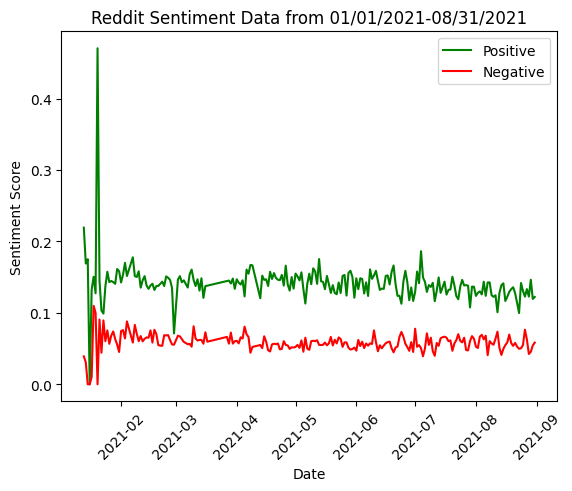

In [45]:
#visualize overall sentiment data
#plot loss functions
visualize_data(x_values=filtered_sentiment_data['Date'],y1_values=filtered_sentiment_data['pos'], y2_values = filtered_sentiment_data['neg'],x_label='Date',y_label='Sentiment Score',
               y1_label='Positive',y2_label='Negative',y1_color='green',y2_color='red',title='Reddit Sentiment Data from 01/01/2021-08/31/2021')

In [46]:
processed_stock_df.shape

(160, 8)

In [47]:
processed_stock_df.columns

Index(['Close', 'Close(t-7)', 'Close(t-6)', 'Close(t-5)', 'Close(t-4)',
       'Close(t-3)', 'Close(t-2)', 'Close(t-1)'],
      dtype='object')

In [48]:
processed_stock_df.reset_index(inplace=True)
processed_stock_df.columns

Index(['Date', 'Close', 'Close(t-7)', 'Close(t-6)', 'Close(t-5)', 'Close(t-4)',
       'Close(t-3)', 'Close(t-2)', 'Close(t-1)'],
      dtype='object')

In [49]:
filtered_sentiment_data.columns

Index(['Date', 'pos', 'neg'], dtype='object')

<h4><b>4. Merge Sentiment Data With Stock Data</b></h4>

<h6><b>We can add the columns 'pos' and 'neg' as features to the normalized stock data; these features don't require it because their values are already between 0 and 1</b></h6>

In [50]:
#rename column to 'Date' for merging
processed_stock_df['Date'] = processed_stock_df['Date'].dt.tz_localize(None)
merged_df = processed_stock_df.merge(filtered_sentiment_data, on='Date', how='left')
merged_df.head()

,Date,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1),pos,neg
0,2021-01-13,7.8500,4.3125,4.3425,4.5900,4.5200,4.4225,4.9850,4.9875,0.219357,0.039071
1,2021-01-14,9.9775,4.3425,4.5900,4.5200,4.4225,4.9850,4.9875,7.8500,0.169000,0.030778
2,2021-01-15,8.8750,4.5900,4.5200,4.4225,4.9850,4.9875,7.8500,9.9775,0.175214,0.000000
3,2021-01-19,9.8400,4.5200,4.4225,4.9850,4.9875,7.8500,9.9775,8.8750,0.127462,0.100231
4,2021-01-20,9.7800,4.4225,4.9850,4.9875,7.8500,9.9775,8.8750,9.8400,0.470500,0.000000


<h4><b>5. Identify and Handle NaN Values</b></h4>

In [51]:
#examine number of NaN values:
nan_counts = merged_df.isna().sum()
print(nan_counts)

Date           0
Close          0
Close(t-7)     0
Close(t-6)     0
Close(t-5)     0
Close(t-4)     0
Close(t-3)     0
Close(t-2)     0
Close(t-1)     0
pos           10
neg           10
dtype: int64


In [52]:
merged_df.shape

(160, 11)

In [53]:
nan_counts = transformed_sentiment_data.isna().sum()
nan_counts

Date    0
pos     0
neg     0
dtype: int64

<p>There are no NaN values in the data obtained from reddit, there appear to be a few after merging it with the historic stock data.</p>

In [54]:
merged_df.head()

,Date,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1),pos,neg
0,2021-01-13,7.8500,4.3125,4.3425,4.5900,4.5200,4.4225,4.9850,4.9875,0.219357,0.039071
1,2021-01-14,9.9775,4.3425,4.5900,4.5200,4.4225,4.9850,4.9875,7.8500,0.169000,0.030778
2,2021-01-15,8.8750,4.5900,4.5200,4.4225,4.9850,4.9875,7.8500,9.9775,0.175214,0.000000
3,2021-01-19,9.8400,4.5200,4.4225,4.9850,4.9875,7.8500,9.9775,8.8750,0.127462,0.100231
4,2021-01-20,9.7800,4.4225,4.9850,4.9875,7.8500,9.9775,8.8750,9.8400,0.470500,0.000000


In [55]:
merged_df.tail()

,Date,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1),pos,neg
155,2021-08-25,49.912498,40.982498,40.887501,39.262501,38.224998,39.825001,41.222500,52.572498,0.130790,0.054910
156,2021-08-26,51.305000,40.887501,39.262501,38.224998,39.825001,41.222500,52.572498,49.912498,0.122797,0.076433
157,2021-08-27,51.237499,39.262501,38.224998,39.825001,41.222500,52.572498,49.912498,51.305000,0.133268,0.062746
158,2021-08-30,52.299999,38.224998,39.825001,41.222500,52.572498,49.912498,51.305000,51.237499,0.119468,0.054340
159,2021-08-31,54.560001,39.825001,41.222500,52.572498,49.912498,51.305000,51.237499,52.299999,0.122323,0.058341


In [56]:
rows_with_nan = merged_df[merged_df.isna().any(axis=1)]

# Display the rows with NaN values
print(rows_with_nan[['Date','pos','neg']]) #verified against actual data - these 10 dates don't exist in the reddit sentiment analysis data

         Date  pos  neg
16 2021-02-05  NaN  NaN
31 2021-03-01  NaN  NaN
44 2021-03-18  NaN  NaN
45 2021-03-19  NaN  NaN
46 2021-03-22  NaN  NaN
47 2021-03-23  NaN  NaN
48 2021-03-24  NaN  NaN
49 2021-03-25  NaN  NaN
50 2021-03-26  NaN  NaN
60 2021-04-12  NaN  NaN


In [57]:
#examine summary statistics for pos
print('Pos mean: ',merged_df['pos'].mean())
print('Pos median: ',merged_df['pos'].median())

#examine summary statistics for neg
print('Neg mean: ',merged_df['neg'].mean())
print('Neg median: ',merged_df['neg'].median())

Pos mean:  0.1426553341115855
Pos median:  0.14074151817332825
Neg mean:  0.05989642326190451
Neg median:  0.05931232920815403


<p>Since the mean and median values are approximately equal, we can perform <b>data imputation</b> using the mean of the respective sentiment score columns - 'pos' and 'neg'.</p>

In [58]:
#since the mean and median values are approximately equal, perform data imputation using mean for sentiment score columns
merged_df['pos'].fillna(merged_df['pos'].mean(), inplace=True)
merged_df['neg'].fillna(merged_df['neg'].mean(), inplace=True)

In [59]:
#verify number of NaN values after data imputation
nan_counts = merged_df.isna().sum()
print(nan_counts)

Date          0
Close         0
Close(t-7)    0
Close(t-6)    0
Close(t-5)    0
Close(t-4)    0
Close(t-3)    0
Close(t-2)    0
Close(t-1)    0
pos           0
neg           0
dtype: int64


In [60]:
pos_values = merged_df['pos'].values
neg_values = merged_df['neg'].values

# Concatenate pos_values and neg_values as new columns to X
# First, reshape pos_values and neg_values to match the dimensions of X
pos_values_reshaped = pos_values.reshape(-1, 1)
neg_values_reshaped = neg_values.reshape(-1, 1)

X_with_sentiment = np.hstack((X_stock, pos_values_reshaped, neg_values_reshaped))

In [61]:
X_with_sentiment.shape

(160, 9)

In [62]:
X_with_sentiment[0]

array([0.        , 0.        , 0.00203141, 0.00118246, 0.        ,
       0.        , 0.        , 0.21935714, 0.03907143])

<h4><b>6. Split Data into train and test sets</b></h4>

In [63]:
sequence_size_sentiment= sequence_size_stock + 2 #adding 2 as this has 2 additional features - 'pos' and 'neg'
X_train_sentiment, y_train_sentiment, X_test_sentiment, y_test_sentiment = split_train_test(X_with_sentiment,y_stock, partition_index,sequence_size_sentiment)
X_test_sentiment.shape, y_test_sentiment.shape

X before reshaping: (95, 9)
X after reshaping: (95, 9, 1)
X after wrapping in tensor: torch.Size([95, 9, 1])


(torch.Size([65, 9, 1]), torch.Size([65, 1]))

In [64]:
#create train and test datasets
train_dataset_sentiment = StockPredictionDataset(X_train_sentiment, y_train_sentiment)
test_dataset_sentiment = StockPredictionDataset(X_test_sentiment, y_test_sentiment)

#wrap the datasets in data loaders for working with batches

batch_size_sentiment = 32

train_loader_sentiment = DataLoader(train_dataset_sentiment, batch_size=batch_size_sentiment, shuffle=True)
test_loader_sentiment = DataLoader(test_dataset_sentiment, batch_size=batch_size_sentiment, shuffle=False)

<h4><b>7. Model Building, Training, Testing and Evaluation</b></h4>

In [65]:
#model building
model_sentiment = LSTM(1,4,1)
model_sentiment.to(device)
model_sentiment

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [66]:
#perform training + testing
sentiment_exec = True

learning_rate_sentiment=0.05
epochs_sentiment=200

performance_sentiment = train_test_model(learning_rate=learning_rate_sentiment, num_epochs=epochs_sentiment, train_loader=train_loader_sentiment, test_loader=test_loader_sentiment,
                                         batch_size=batch_size_sentiment, model=model_sentiment)

performance_df_sentiment = pd.DataFrame(performance_sentiment, columns=['Epoch', 'Training Loss', 'Testing Loss'])

In [67]:
#view training and testing losses in tabular format
performance_df_temp_sentiment = performance_df_sentiment.style.hide(axis="index")
display(performance_df_temp_sentiment)

Epoch,Training Loss,Testing Loss
1,0.281133,0.014554
2,0.115958,0.012407
3,0.066177,0.049355
4,0.055529,0.111838
5,0.066815,0.098883
6,0.055006,0.049866
7,0.045215,0.021850
8,0.052558,0.016327
9,0.052078,0.027188
10,0.045539,0.046441


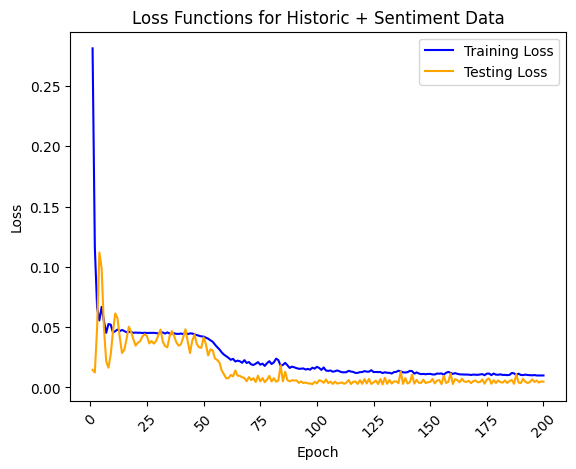

In [68]:
#plot loss functions
visualize_data(x_values=performance_df_sentiment['Epoch'],y1_values=performance_df_sentiment['Training Loss'], y2_values = performance_df_sentiment['Testing Loss'],x_label='Epoch',y_label='Loss',
               y1_label='Training Loss',y2_label='Testing Loss',y1_color='blue',y2_color='orange',title='Loss Functions for Historic + Sentiment Data')

In [69]:
#make adjustments before calling the visualization method
training_sentiment_data = merged_df.iloc[:partition_index]

<h4><b>8. View Actual Versus Predicted Values</b></h4>

y range:  7.849999904632568 86.87750244140626


Mean Squared Error (MSE): 60.92041072491376
Root Mean Squared Error (RMSE): 7.805152831617954
Mean Absolute Error (MAE): 4.581051165787612


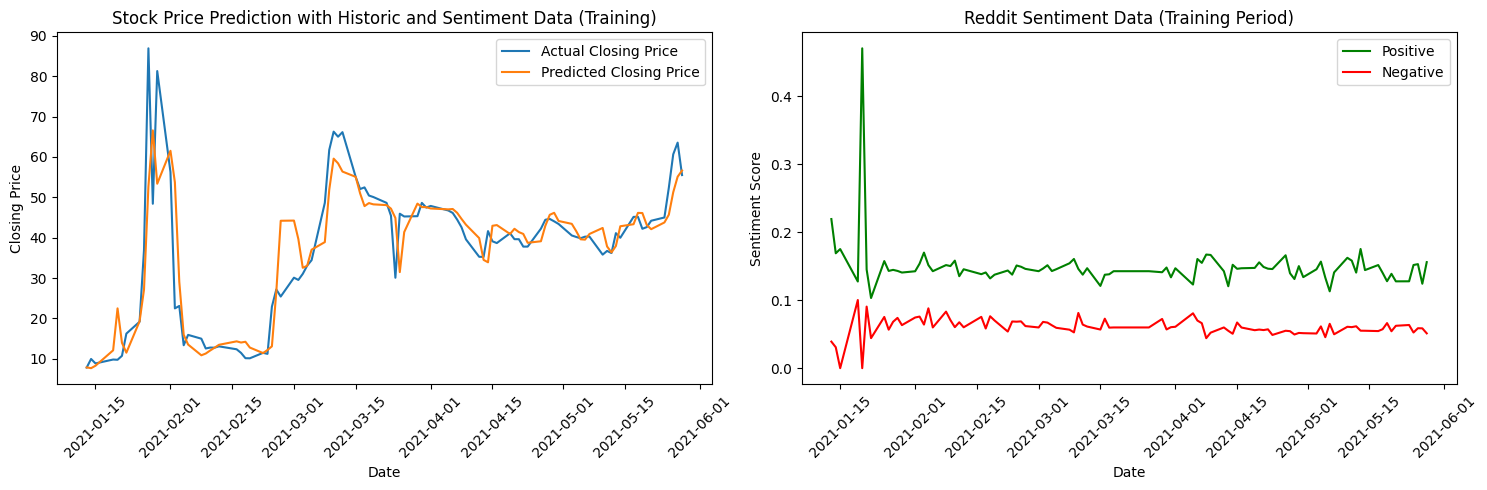

In [70]:
sentiment_exec = True
#visualize stock prediction and sentiment data for that time period for training data
visualize_sentiment_pred_data(pred_x_values=X_train_sentiment,pred_label='Stock Price Prediction with Historic and Sentiment Data (Training)',pred_y_values=y_train_sentiment,sentiment_label='Reddit Sentiment Data (Training Period)',sentiment_x_values=training_sentiment_data['Date'], sentiment_y_neg_values=training_sentiment_data['neg'],sentiment_y_pos_values=training_sentiment_data['pos'],seq_size=sequence_size_stock,model = model_sentiment, pred_bool_val=False)

In [71]:
training_sentiment_data.shape

(95, 11)

In [72]:
#X_temp_test = X_test[:, :7, :]
testing_sentiment_data = merged_df.iloc[partition_index:]

y range:  36.700001497168714 75.63999938118934


Mean Squared Error (MSE): 28.80181143838042
Root Mean Squared Error (RMSE): 5.366731914152264
Mean Absolute Error (MAE): 3.471653335264859


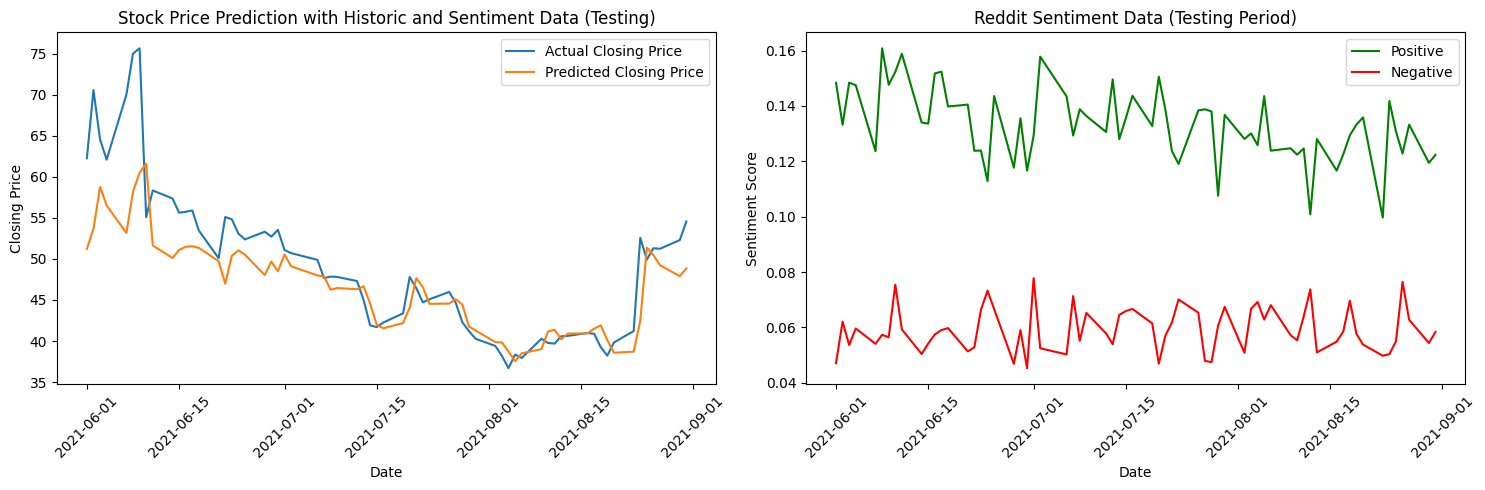

In [73]:
#visualize stock prediction and sentiment data for that time period for testing data
visualize_sentiment_pred_data(pred_x_values=X_test_sentiment,pred_label='Stock Price Prediction with Historic and Sentiment Data (Testing)',pred_y_values=y_test_sentiment,sentiment_label='Reddit Sentiment Data (Testing Period)',sentiment_x_values=testing_sentiment_data['Date'], sentiment_y_neg_values=testing_sentiment_data['neg'],sentiment_y_pos_values=testing_sentiment_data['pos'],seq_size=sequence_size_stock,model = model_sentiment, pred_bool_val=True)